$$ \Huge K-Means ~ Clustering $$
$$Minh ~ Kha$$

In [1]:
%matplotlib inline

In [2]:
from IPython.display import clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv("handwritten/train.csv")
test  = pd.read_csv("handwritten/test.csv")

print("Training set has {0[0]} rows and {0[1]} columns".format(train.shape))
print("Test set has {0[0]} rows and {0[1]} columns".format(test.shape))

Training set has 42000 rows and 785 columns
Test set has 28000 rows and 784 columns


### Divide the train data into two set: 80% for training_set, 20% for validation_set

In [4]:
training_set, validation_set = train_test_split(train, train_size=0.8, test_size=0.2, shuffle=True)
print(training_set.shape)
print(validation_set.shape)

(33600, 785)
(8400, 785)


In [5]:
trainlabels = np.asmatrix(training_set.loc[:, 'label'])
traindata = np.asmatrix(training_set.loc[:,'pixel0':])
print(trainlabels.shape)
print(traindata.shape)

(1, 33600)
(33600, 784)


In [6]:
validation_labels = np.asmatrix(validation_set.loc[:, 'label'])
validation_data = np.asmatrix(validation_set.loc[:, 'pixel0':])
print(validation_labels.shape)
print(validation_data.shape)

(1, 8400)
(8400, 784)


In [8]:
def show_image(index, labels, data):
    print("Label: ", labels[0, index])
    samplerow = data[index:index+1]
    samplerow = np.reshape(samplerow,(28,28))
    fig = plt.imshow(samplerow)
    fig.set_cmap('gray_r')
    plt.show()

Label:  9


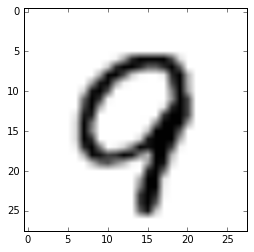

In [9]:
show_image(1997, trainlabels, traindata)

In [10]:
from scipy.spatial.distance import cdist

In [11]:
def kmeans_init_centers(X, k):
    # X (N x d)
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace = False)]

def kmeans_get_closest_centroid_indices(X, centers):
    # calculate pairwise distance between data points and centers
    D = cdist(X, centers)
    # return index of the closest centers
    return np.argmin(D, axis=1)

def kmeans_update_centers(X, labels, K):
    """
    returns list of mean centroids corresponding to clusters.
    """
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the kth cluster
        Xk = X[labels == k][:]
        # take average
        centroids[k,:] = np.mean(Xk, axis=0)
    return centroids
        
def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set(np.asarray(centers).ravel()) ==
        set(np.asarray(new_centers).ravel()))

In [12]:
def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    while True:
        print(it, end=' ')
        closest_centroid_indices = kmeans_get_closest_centroid_indices(X, centers[-1])
        labels.append(closest_centroid_indices)
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break
        centers.append(new_centers)
        it += 1
    print('!!!')
    return (centers, labels, it)

In [13]:
# 10 digits
K = 10

(centers, labels, it) = kmeans(traindata, K)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 !!!


In [14]:
print ('Centers found by our algorithm:')
print(centers[-1].shape)
print (centers[-1])
print(np.asarray(labels).shape)
print(labels[-1].shape)
print(labels[-1])

Centers found by our algorithm:
(10, 784)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(47, 33600)
(33600,)
[8 7 6 ..., 3 9 0]


## Using Scikit-learn

In [15]:
from sklearn.cluster import KMeans
sklearn_kmeans = KMeans(n_clusters=10, random_state=10).fit(traindata)
print('!!!')

!!!


In [16]:
print ('Centers found by scikit-learn:')
print (sklearn_kmeans.cluster_centers_)
print(sklearn_kmeans.labels_)

Centers found by scikit-learn:
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[2 0 1 ..., 1 3 3]


## Assign class labels to centroids

In [20]:
# https://johnloeber.com/docs/kmeans.html

def form_cluster(cluster_ids, labels, K):
    # initialize an empty list for each centroid. The list will contain
    # all the datapoints that are closer to that centroid than to any other.
    # That list is the cluster of that centroid.
    clusters = {c: [] for c in range(K)}
    
    for (idx, val) in enumerate(cluster_ids):
        clusters[val].append(labels[idx])
    
    return clusters

def find_most_common_label(cluster):
    frequencies = {}
    most_common_freq = 0
    most_common_label = 0
    for cluster_labels in cluster:
        if cluster_labels in frequencies:
            frequencies[cluster_labels] += 1
        else:
            frequencies[cluster_labels] = 1
        if frequencies[cluster_labels] > most_common_freq:
            most_common_freq = frequencies[cluster_labels]
            most_common_label = cluster_labels
    return (most_common_label, most_common_freq)

def assign_labels_to_centroids(clusters, centroids):
    """
    Assigns a digit label to each centroid
    """
    labelled_centroids = []
    for ids in range(len(clusters)):
        # pick the most common label according to the frequency of each label
        (most_common_label, most_common_freq) = find_most_common_label(clusters[ids])             
        
        centroid = (most_common_label, centroids[ids])
        labelled_centroids.append(centroid)
    return labelled_centroids

In [36]:
ravel_trainlabels = np.asarray(trainlabels).ravel()
ravel_validationlabels = np.asarray(validation_labels).ravel()
print(ravel_trainlabels)
print(len(ravel_trainlabels))
print(ravel_validationlabels)
print(len(ravel_validationlabels))

[2 8 0 ..., 6 4 4]
33600
[0 2 4 ..., 2 6 6]
8400


In [22]:
clusters = form_cluster(labels[-1], ravel_trainlabels, 10)
print(len(clusters))
# for i in clusters:
#     print(len(clusters[i]))
# print(clusters[0])
labelled_centroids = assign_labels_to_centroids(clusters, centers)
print(len(labelled_centroids))
print(labelled_centroids[0][0])

10
10
4


In [23]:
tmp = clusters.copy()
for i in tmp:
    label_of_labelled_centroids = labelled_centroids[i][0]
    for (idx, j) in enumerate(tmp[i]):
        tmp[i][idx] = label_of_labelled_centroids

print(tmp)

{0: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [30]:
new_labels = []
for i in labels[-1]:
    new_labels.append(tmp[i][0])
print(len(new_labels))

33600


## Calculate accuracy for training set

In [33]:
def calc_accuracy(predictedLabels, actualLabels, X):
    mis_points = 0
    for i in (actualLabels):
        predicted = predictedLabels[i]
        actual = actualLabels[i]
#         print('Predicted: ', predicted)
#         print('Actual: ', actual)
#         show_image(i, actualLabels, X)
    #     plt.show()
    #     time.sleep(1)
        if predicted != actual:
            mis_points += 1

    accuracy = mis_points / len(actualLabels)
    print(mis_points)
    print('Accuracy: ', 100 - np.round(accuracy*100, 2), '%')   

In [34]:
calc_accuracy(new_labels, ravel_trainlabels, traindata)

6757
Accuracy:  79.89 %


## Classify and get error rate for validation set

In [59]:
def classify_digit(digit, labelled_centroids):
    """
    given an unlabelled digit represented by a vector and a list of
    labelled centroids [(label,vector)], determine closest centroid
    and thus classify the digit.
    """
    min_dist = np.float("inf")
    for (label, centroid) in labelled_centroids:
        dist = np.linalg.norm(centroid - digit)
        if dist < min_dist:
            min_dist = dist
            closest_centroid_label = label
    return closest_centroid_label

def get_error_rate(labels, digits,labelled_centroids):
    """
    classifies a list of labelled digits. returns the error rate.
    """
    classified_incorrect = 0
    for idx in range(len(digits)):
        classified_label =classify_digit(digits[idx, :], labelled_centroids)
        if classified_label != labels[idx]:
            classified_incorrect +=1
    error_rate = classified_incorrect / float(len(digits))
    print(classified_incorrect)
    print(len(digits))
    print(error_rate*100, ' %')
    return error_rate

In [53]:
print(validation_labels.shape)
print(validation_data.shape)

(1, 8400)
(8400, 784)


In [60]:
get_error_rate(validation_labels.T, validation_data, labelled_centroids)

8262
8400
98.35714285714286  %


0.9835714285714285